# Backtesting ML Classification-Based

In [ ]:
???

![](src/res_classification.png)

## Load the model

In [1]:
import pickle

In [2]:
with open('models/model_dt_classification.pkl', 'rb') as f:
    model_dt = pickle.load(f)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
model_dt

DecisionTreeClassifier(max_depth=15)

## Load the data

In [4]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', index_col=0, parse_dates=['Date'])
df

,Open,High,Low,Close,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,
2016-12-08,56.325228,56.582507,55.902560,56.058762,21220800,1.549143,UP
2016-12-09,56.214968,56.959234,56.169027,56.940857,27349400,0.321692,UP
...,...,...,...,...,...,...,...
2023-03-14,256.750000,261.070007,255.860001,260.790009,33620300,1.751806,UP
2023-03-15,259.980011,266.480011,259.209991,265.440002,46028000,3.895731,UP


## Backtesting.py Library

### Create your Strategy Class

In [5]:
from backtesting import Backtest, Strategy

In [6]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [7]:
df_explanatory.iloc[-1:, :]

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-15,259.980011,266.480011,259.209991,265.440002,46028000


In [8]:
df.change_tomorrow_direction[-1:]

Date
2023-03-15    UP
Name: change_tomorrow_direction, dtype: object

#### Simulate the prediction for the last observation

In [9]:
model_dt.predict(X=df_explanatory)

array(['UP', 'UP', 'UP', ..., 'UP', 'DOWN', 'UP'], dtype=object)

In [19]:
explanatory_today = df_explanatory.iloc[[-1],:]

In [20]:
forecast_tomorrow = model_dt.predict(explanatory_today)[0]

#### Write the prediction process in the Strategy class

In [21]:
class ClassificationUP(Strategy):
    def init(self):
        self.model = model_dt

    def next(self):
        explanatory_today = df_explanatory.iloc[[-1],:]
        forecast_tomorrow = model_dt.predict(explanatory_today)[0]
        
        # conditions to sell or buy

#### Calculate Purchase Recommendation

##### Buy if it goes up

In [22]:
list_buy = []

In [23]:
for direction_tomorrow in df.change_tomorrow_direction:
    if direction_tomorrow == 'UP':
        list_buy.append(1)
    else:
        list_buy.append(0)

In [24]:
df['buy'] = list_buy

In [25]:
df

,Open,High,Low,Close,Volume,change_tomorrow,change_tomorrow_direction,buy
Date,,,,,,,,
2016-12-08,56.325228,56.582507,55.902560,56.058762,21220800,1.549143,UP,1
2016-12-09,56.214968,56.959234,56.169027,56.940857,27349400,0.321692,UP,1
...,...,...,...,...,...,...,...,...
2023-03-14,256.750000,261.070007,255.860001,260.790009,33620300,1.751806,UP,1
2023-03-15,259.980011,266.480011,259.209991,265.440002,46028000,3.895731,UP,1


##### Buy if it goes and sell if down

> You can only sell if you have already bought

In [26]:
list_buy_sell = []
already_bought = False

In [27]:
for direction_tomorrow in df.change_tomorrow_direction:
    if direction_tomorrow == 'UP' and already_bought == False:
        list_buy_sell.append(1)
        already_bought = True
    elif direction_tomorrow == 'DOWN' and already_bought == True:
        list_buy_sell.append(-1)
        already_bought = False
    else:
        list_buy_sell.append(0)

In [28]:
df['buy_sell'] = list_buy_sell

In [29]:
df

,Open,High,Low,Close,Volume,change_tomorrow,change_tomorrow_direction,buy,buy_sell
Date,,,,,,,,,
2016-12-08,56.325228,56.582507,55.902560,56.058762,21220800,1.549143,UP,1,1
2016-12-09,56.214968,56.959234,56.169027,56.940857,27349400,0.321692,UP,1,0
...,...,...,...,...,...,...,...,...,...
2023-03-14,256.750000,261.070007,255.860001,260.790009,33620300,1.751806,UP,1,0
2023-03-15,259.980011,266.480011,259.209991,265.440002,46028000,3.895731,UP,1,0


#### Add conditions to the strategy

In [30]:
class SimpleClassificationUD(Strategy):
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[-1:, :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        # conditions to sell or buy
        if forecast_tomorrow == 'UP' and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow == 'DOWN' and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Define initial conditions

In [31]:
bt = Backtest(df_explanatory, SimpleClassificationUD,
              cash=10000, commission=.002, exclusive_orders=True)

### Run backtesting

In [39]:
results = bt.run()

### Interpret backtesting results

In [40]:
results.to_frame(name='Values').loc[:'Return [%]']

,Values
Start,2016-12-08 00:00:00
End,2023-03-15 00:00:00
Duration,2288 days 00:00:00
Exposure Time [%],99.873096
Equity Final [$],38432829.251776
Equity Peak [$],38432829.251776
Return [%],384228.292518


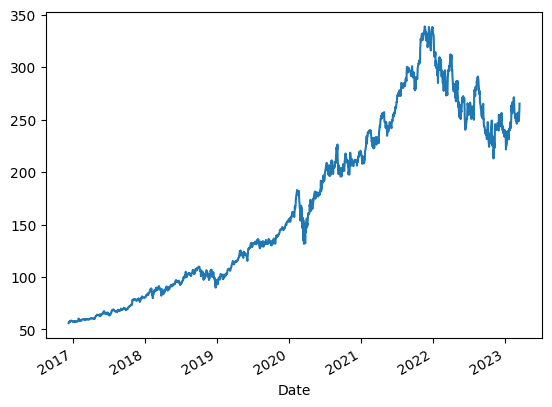

In [41]:
df.Close.plot();

## Practice to master the knowledge

Work on the challenge with another dataset:

1. Learn the <a>mental models</a> to solve the challenge faster.
2. Complete the <a href="03D_Backtesting ML Classification-Based.ipynb">notebook</a>.